In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv("../data/ssbci_data_withclusters.csv")
df.loc[df['jobs_created'] > 0, 'creation_status'] = 1
df.loc[df['jobs_created'] == 0, 'creation_status'] = 0
df.drop(['state_id','full_time_employees', 'Unnamed: 0','borrower_insurance_premium',
         'lender_insurance_premium','jobs_created','job_benefit'], axis=1, inplace=True)
df.head()

,program_type,loan_investment_amount,ssbci_original_funds,nonprivate_amount,concurrent_private_financing,guaranteed_amount,collateral_support,ssbci_recycled_funds,subsequent_private_financing,metro_type,...,revenue,naics_code,year_incorporated,jobs_retained,trans_type,CDFI_type,SPY_Close,U_Rate,kproto,creation_status
0,Venture Capital,180000.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,Metro,...,0.0,541511,2013,1.0,VC,VC,152.110001,7.5,6,1.0
1,Venture Capital,2400000.0,250000.0,0.0,0.0,0.0,0.0,0.0,1520000.0,Metro,...,0.0,423930,2012,0.0,VC,VC,167.509995,7.3,2,1.0
2,Venture Capital,265000.0,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,Metro,...,0.0,541511,2013,5.0,VC,VC,183.820007,6.7,6,1.0
3,Venture Capital,199500.0,99750.0,0.0,0.0,0.0,0.0,0.0,0.0,Metro,...,0.0,336612,2014,0.0,VC,VC,181.509995,6.2,6,1.0
4,Venture Capital,125000.0,62500.0,0.0,125000.0,0.0,0.0,0.0,0.0,Metro,...,1494916.0,451110,2007,0.0,VC,VC,187.399994,6.3,6,1.0


In [45]:
ssbci_obj_cols = df.select_dtypes(exclude=[np.float64]).columns
ssbci_int_cols = ['naics_code','year_incorporated']
#ssbci_obj_cols.append(ssbci_int_cols)
ssbci_obj_cols

Index(['program_type', 'metro_type', 'LMI_type', 'naics_code',
       'year_incorporated', 'trans_type', 'CDFI_type', 'kproto'],
      dtype='object')

In [46]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for i in ssbci_obj_cols:
    df[i] = label_encoder.fit_transform(df[i])

print("Label Encoded Data: ")
df.head()

Label Encoded Data: 


,program_type,loan_investment_amount,ssbci_original_funds,nonprivate_amount,concurrent_private_financing,guaranteed_amount,collateral_support,ssbci_recycled_funds,subsequent_private_financing,metro_type,...,revenue,naics_code,year_incorporated,jobs_retained,trans_type,CDFI_type,SPY_Close,U_Rate,kproto,creation_status
0,4,180000.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,681,103,1.0,1,2,152.110001,7.5,6,1.0
1,4,2400000.0,250000.0,0.0,0.0,0.0,0.0,0.0,1520000.0,0,...,0.0,439,102,0.0,1,2,167.509995,7.3,2,1.0
2,4,265000.0,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,681,103,5.0,1,2,183.820007,6.7,6,1.0
3,4,199500.0,99750.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,378,104,0.0,1,2,181.509995,6.2,6,1.0
4,4,125000.0,62500.0,0.0,125000.0,0.0,0.0,0.0,0.0,0,...,1494916.0,519,97,0.0,1,2,187.399994,6.3,6,1.0


In [47]:
X = df.copy()
X.drop("creation_status", inplace = True, axis = 1)
Y = df.creation_status

In [48]:
#X_train, X_test = X[:int(X.shape[0]*0.8)].values, X[int(X.shape[0]*0.8):].values
#Y_train, Y_test = Y[:int(X.shape[0]*0.8)].values, Y[int(X.shape[0]*0.8):].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
test_size=0.2, random_state=42)


In [49]:
train = xgb.DMatrix(X_train, label = Y_train)
test = xgb.DMatrix(X_test, label = Y_test)

In [50]:
param = {'max_depth' : 20, 'eta' : 0.3, 'verbosity' : 0, 'objective' : 'binary:hinge', 
         'eval_metric': 'aucpr', 'predictor':'gpu_predictor'}
num_rounds = 5
model = xgb.train(param, train, num_rounds)

In [51]:
preds = model.predict(test)

In [52]:
import pickle
pickle.dump(model, open("model.dat", "wb"))

model.save_model("model.json")

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score

print('Confusion matrix')
print(confusion_matrix(Y_test, preds))
acc = accuracy_score(Y_test, preds)
print(f'Accuracy: {acc: .2%}')
pr = precision_score(Y_test, preds)
print(f'Precision: {pr: .2%}')
re = recall_score(Y_test, preds)
print(f'Recall score: {re: .2%}')
f1 = f1_score(Y_test, preds)
print(f'F1 score: {f1: .2%}')

Confusion matrix
[[1837  697]
 [ 458 1401]]
Accuracy:  73.71%
Precision:  66.78%
Recall score:  75.36%
F1 score:  70.81%


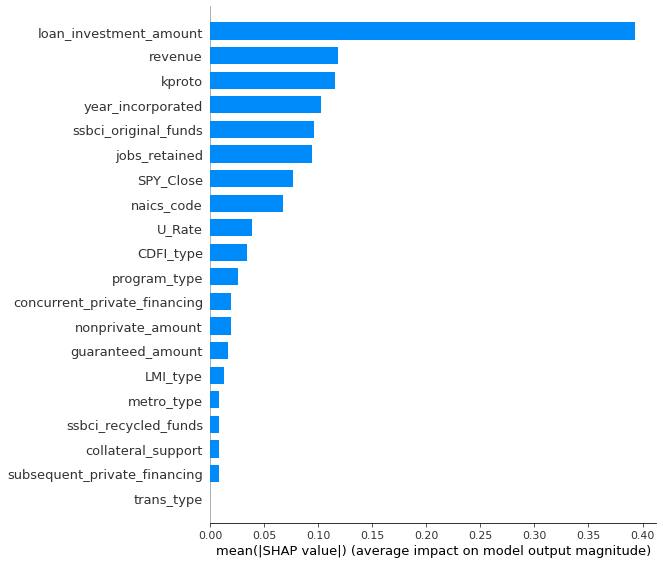

In [54]:
import shap

explainer_km = shap.TreeExplainer(model)
shap_values_km = explainer_km.shap_values(X)
shap.summary_plot(shap_values_km, X, plot_type="bar")

In [55]:
import joblib
joblib.dump(model, 'model.pkl')
print("Model dumped!")

Model dumped!


In [56]:
# Load the model that you just saved
model = joblib.load('model.pkl')

# Saving the data columns from training
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")


Models columns dumped!
